In [1]:
import torch
import numpy as np
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

device = torch.device("cuda:0")

C:\Users\ShankRam\miniconda3\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)
classNames = [0,1,2,3,4,5,6,7,8,9]

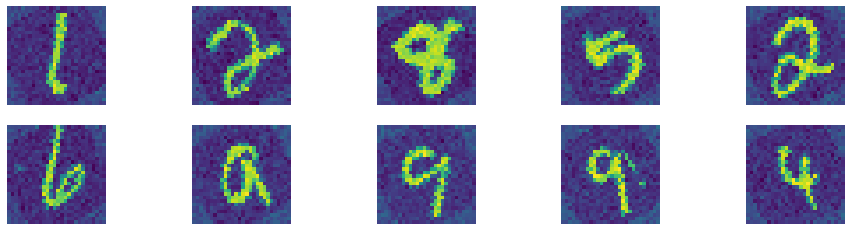

In [3]:
def imshow(img, plot):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plot.imshow(np.transpose(npimg, (1,2,0)))
    
plt.figure(figsize = (16,4))

img_batch, label_batch = next(iter(train_loader))

img_batch = torchvision.transforms.functional.rotate(img_batch, 30)

for i in range(10):
    img = img_batch[i]
    img = img + torch.randn_like(img)*0.2
    label = label_batch[i]
    plt.subplot(2,5,i+1)
    imshow(img,plt)
    plt.axis('off')

In [4]:
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

## Data Augmentation. Adding Gaussian Noise, rotating images and producing a dataset 3x the size of the original one

In [5]:
def train(epoch, model):
    model.train() #sets the model to train mode so the layers behave as intended (eg. batch norm and dropout layers)
    for batch_idx, (data, target) in enumerate(train_loader):
        data = torch.cat((data, torchvision.transforms.functional.rotate(data, 30), data + torch.randn_like(data)*0.2))
        target = torch.cat((target, target, target))
        
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.cuda(), target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0 :
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data) *3, len(train_loader.dataset)*3,
                100. * batch_idx / (len(train_loader)*3), loss.item()))

In [14]:
def train2(epoch, model):
    model.train() #sets the model to train mode so the layers behave as intended (eg. batch norm and dropout layers)
    for batch_idx, (data, target) in enumerate(train_loader):
     
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.cuda(), target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0 :
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data) *3, len(train_loader.dataset)*3,
                100. * batch_idx / (len(train_loader)*3), loss.item()))

In [6]:
accuracy_list = []

def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss = F.nll_loss(output.cuda(), target, reduction = "mean").item()
        pred = output.data.max(1, keepdim = True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
        
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct/len(test_loader.dataset)
    accuracy_list.append(accuracy)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [7]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, 50), 
            nn.ReLU(), 
            nn.Linear(50,50),
            nn.ReLU(),
            nn.Linear(50,30), 
            nn.ReLU(), 
            nn.Linear(30, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

In [8]:
print("Training on device : ", device)
model_fnn = FC2Layer(input_size, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.1)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0,5):
    train(epoch, model_fnn)
    test(model_fnn)

Training on device :  cuda:0
Number of parameters: 43640
Train Epoch: 0 [0/180000 (0%)]	Loss: 2.321442
Train Epoch: 0 [19200/180000 (4%)]	Loss: 0.847235
Train Epoch: 0 [38400/180000 (7%)]	Loss: 0.440363
Train Epoch: 0 [57600/180000 (11%)]	Loss: 0.509047
Train Epoch: 0 [76800/180000 (14%)]	Loss: 0.665160
Train Epoch: 0 [96000/180000 (18%)]	Loss: 0.351868
Train Epoch: 0 [115200/180000 (21%)]	Loss: 0.254876
Train Epoch: 0 [134400/180000 (25%)]	Loss: 0.233851
Train Epoch: 0 [153600/180000 (28%)]	Loss: 0.285049
Train Epoch: 0 [172800/180000 (32%)]	Loss: 0.411396

Test set: Average loss: 0.0000, Accuracy: 9428/10000 (94%)

Train Epoch: 1 [0/180000 (0%)]	Loss: 0.431810
Train Epoch: 1 [19200/180000 (4%)]	Loss: 0.218695
Train Epoch: 1 [38400/180000 (7%)]	Loss: 0.080372
Train Epoch: 1 [57600/180000 (11%)]	Loss: 0.117910
Train Epoch: 1 [76800/180000 (14%)]	Loss: 0.253380
Train Epoch: 1 [96000/180000 (18%)]	Loss: 0.050322
Train Epoch: 1 [115200/180000 (21%)]	Loss: 0.172216
Train Epoch: 1 [134400/1

## Very good accuracy. 97\%!

## Added L2 regularization. Not very effective since we are already doing data augmentation and the problem is simple enough

In [13]:
print("Training on device : ", device)
model_fnn_reg = FC2Layer(input_size, output_size)
model_fnn_reg.to(device)
optimizer = optim.SGD(model_fnn_reg.parameters(), lr=0.1, weight_decay = 1e-4)
print('Number of parameters: {}'.format(get_n_params(model_fnn_reg)))

for epoch in range(0,5):
    train(epoch, model_fnn_reg)
    test(model_fnn_reg)

Training on device :  cuda:0
Number of parameters: 43640
Train Epoch: 0 [0/180000 (0%)]	Loss: 2.300196
Train Epoch: 0 [19200/180000 (4%)]	Loss: 0.773278
Train Epoch: 0 [38400/180000 (7%)]	Loss: 0.383715
Train Epoch: 0 [57600/180000 (11%)]	Loss: 0.448855
Train Epoch: 0 [76800/180000 (14%)]	Loss: 0.361265
Train Epoch: 0 [96000/180000 (18%)]	Loss: 0.261714
Train Epoch: 0 [115200/180000 (21%)]	Loss: 0.253057
Train Epoch: 0 [134400/180000 (25%)]	Loss: 0.392370
Train Epoch: 0 [153600/180000 (28%)]	Loss: 0.185669
Train Epoch: 0 [172800/180000 (32%)]	Loss: 0.248676

Test set: Average loss: 0.0000, Accuracy: 9396/10000 (94%)

Train Epoch: 1 [0/180000 (0%)]	Loss: 0.270582
Train Epoch: 1 [19200/180000 (4%)]	Loss: 0.215067
Train Epoch: 1 [38400/180000 (7%)]	Loss: 0.485352
Train Epoch: 1 [57600/180000 (11%)]	Loss: 0.100314
Train Epoch: 1 [76800/180000 (14%)]	Loss: 0.085186
Train Epoch: 1 [96000/180000 (18%)]	Loss: 0.291999
Train Epoch: 1 [115200/180000 (21%)]	Loss: 0.209937
Train Epoch: 1 [134400/1

## L2 regularization without data augmentation

In [15]:
print("Training on device : ", device)
model_fnn_reg = FC2Layer(input_size, output_size)
model_fnn_reg.to(device)
optimizer = optim.SGD(model_fnn_reg.parameters(), lr=0.1, weight_decay = 1e-4)
print('Number of parameters: {}'.format(get_n_params(model_fnn_reg)))

for epoch in range(0,5):
    train2(epoch, model_fnn_reg)
    test(model_fnn_reg)

Training on device :  cuda:0
Number of parameters: 43640
Train Epoch: 0 [0/180000 (0%)]	Loss: 2.359108
Train Epoch: 0 [19200/180000 (4%)]	Loss: 0.820464
Train Epoch: 0 [38400/180000 (7%)]	Loss: 0.418558
Train Epoch: 0 [57600/180000 (11%)]	Loss: 0.455154
Train Epoch: 0 [76800/180000 (14%)]	Loss: 0.320974
Train Epoch: 0 [96000/180000 (18%)]	Loss: 0.236765
Train Epoch: 0 [115200/180000 (21%)]	Loss: 0.148384
Train Epoch: 0 [134400/180000 (25%)]	Loss: 0.160268
Train Epoch: 0 [153600/180000 (28%)]	Loss: 0.298295
Train Epoch: 0 [172800/180000 (32%)]	Loss: 0.327471

Test set: Average loss: 0.0000, Accuracy: 9496/10000 (95%)

Train Epoch: 1 [0/180000 (0%)]	Loss: 0.084558
Train Epoch: 1 [19200/180000 (4%)]	Loss: 0.196838
Train Epoch: 1 [38400/180000 (7%)]	Loss: 0.145328
Train Epoch: 1 [57600/180000 (11%)]	Loss: 0.144053
Train Epoch: 1 [76800/180000 (14%)]	Loss: 0.077672
Train Epoch: 1 [96000/180000 (18%)]	Loss: 0.416450
Train Epoch: 1 [115200/180000 (21%)]	Loss: 0.068013
Train Epoch: 1 [134400/1

In [9]:
def visualize_pred(img, pred_prob, real_label):
    ''' Function for viewing an image and it's predicted classes.
    '''
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    imshow(img, ax1)
    ax1.axis('off')
    pred_label = np.argmax(pred_prob)
    ax1.set_title([classNames[real_label], classNames[pred_label]])
    
    ax2.barh(np.arange(10), pred_prob)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Prediction Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

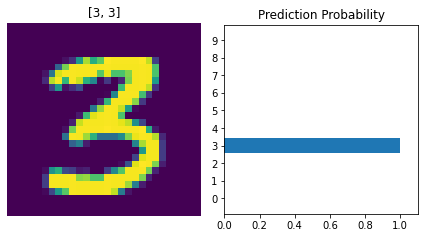

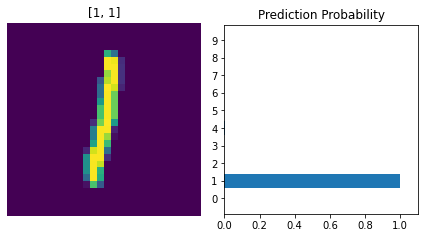

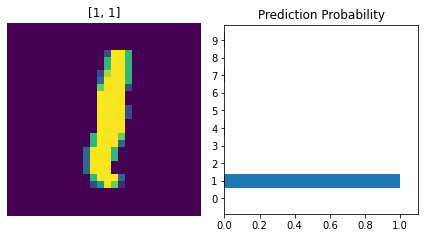

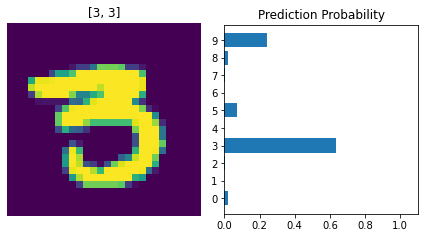

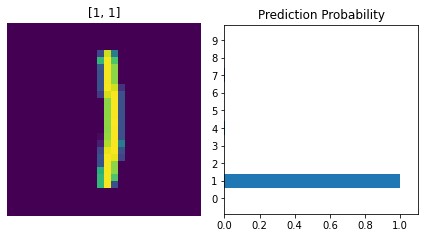

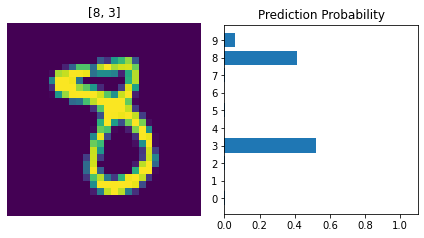

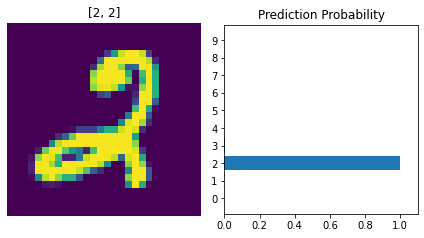

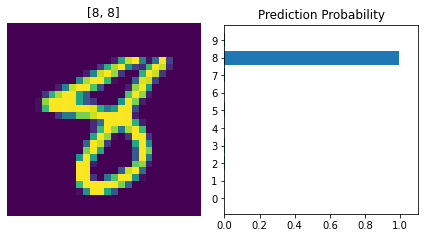

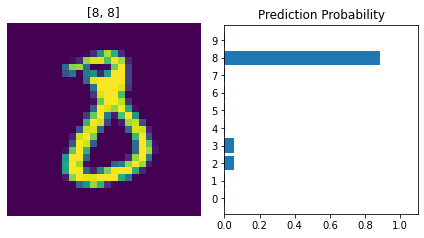

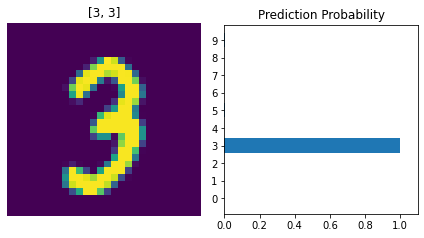

In [10]:
model_fnn.to('cpu') 

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))

# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_fnn(image_batch)
for i in range(10):
    img = image_batch[i]
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img, pred_prob, real_label)